In [7]:
import math
import keras
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

from keras.models import Sequential, model_from_json
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from google.colab import files

plt.style.use('default')

In [3]:
market = 'BTC-GBP'
granularity = 3600

In [4]:
def getHistoricalData(market: str='BTC-GBP', granularity: int=3600, iso8601start: str='', iso8601end: str='') -> pd.DataFrame:
  if iso8601start != '' and iso8601end == '':
    resp = requests.get(f'https://api.pro.coinbase.com/products/{market}/candles?granularity={granularity}&start={iso8601start}')
  elif iso8601start != '' and iso8601end != '':
    resp = requests.get(f'https://api.pro.coinbase.com/products/{market}/candles?granularity={granularity}&start={iso8601start}&end={iso8601end}')
  else:
    resp = requests.get(f'https://api.pro.coinbase.com/products/{market}/candles?granularity={granularity}')

  df = pd.DataFrame.from_dict(resp.json())
  df.columns = [ 'epoch','low','high','open','close','volume' ]

  tsidx = pd.DatetimeIndex(pd.to_datetime(df['epoch'], unit='s'), dtype='datetime64[ns]')
  df.set_index(tsidx, inplace=True)
  df = df.drop(columns=['epoch'])
  df.index.names = ['date']

  return df.iloc[::-1].reset_index()

In [5]:
def getHistoricalDataChained(market: str='BTC-GBP', granularity: int=3600, max_interations: int=1) -> pd.DataFrame:
  df1 = getHistoricalData(market, granularity)

  if max_interations == 1:
    return df1

  def getPreviousDateRange(df: pd.DataFrame=None) -> tuple:
    end_date = df['date'].min() - timedelta(seconds=(granularity/60))
    new_start = df['date'].min() - timedelta(hours=300*(granularity/60/60))
    return (str(new_start).replace(' ', 'T'), str(end_date).replace(' ', 'T'))

  iterations = 0
  result_df = pd.DataFrame()
  while iterations < (max_interations - 1):
    start_date, end_date = getPreviousDateRange(df1)
    df2 = getHistoricalData(market, granularity, start_date, end_date)
    result_df = pd.concat([df2, df1]).drop_duplicates()
    df1 = result_df
    iterations = iterations + 1

  if 'date'in result_df:
    result_df.sort_values(by=['date'], ascending=True, inplace=True)
        
  return result_df

In [11]:
iterations = math.ceil((525600/(granularity/60))/300) # minutes in a year divided by 300 data size
df = getHistoricalDataChained(market, granularity, iterations)
iterations, df.shape, df['date'].min(), df['date'].max()

(30,
 (8998, 6),
 Timestamp('2020-06-12 23:00:00'),
 Timestamp('2021-06-22 22:00:00'))

In [12]:
df.head()

,date,low,high,open,close,volume
0,2020-06-12 23:00:00,7544.99,7572.00,7568.00,7566.99,16.597392
1,2020-06-13 00:00:00,7540.00,7571.96,7562.31,7553.36,10.123786
2,2020-06-13 01:00:00,7537.00,7556.88,7549.80,7550.44,5.513568
3,2020-06-13 02:00:00,7526.39,7552.20,7552.20,7534.76,5.921088
4,2020-06-13 03:00:00,7514.00,7537.42,7534.73,7514.00,4.377042


In [13]:
df['ema12'] = df['close'].ewm(span=12, adjust=False).mean()
df['ema26'] = df['close'].ewm(span=26, adjust=False).mean()

df['macd'] = df['ema12'] - df['ema26']
df['signal'] = df['macd'].ewm(span=9, adjust=False).mean() 

df['obv'] = np.where(df['close'] == df['close'].shift(1), 0, np.where(df['close'] > df['close'].shift(1), df['volume'], 
        np.where(df['close'] < df['close'].shift(1), -df['volume'], df.iloc[0]['volume']))).cumsum() # on-balance volume
df['obv_pc'] = df['obv'].pct_change() * 100
df['obv_pc'] = round(df['obv_pc'].fillna(0), 2) # on-balance volume as a percentage

df['close_delta'] = df['close'].diff().fillna(0) # delta between adj close

df['next_close'] = df['close'].shift(-1)
df.dropna(inplace=True)
df

,date,low,high,open,close,volume,ema12,ema26,macd,signal,obv,obv_pc,close_delta,next_close
0,2020-06-12 23:00:00,7544.99,7572.00,7568.00,7566.99,16.597392,7566.990000,7566.990000,0.000000,0.000000,16.597392,0.00,0.00,7553.36
1,2020-06-13 00:00:00,7540.00,7571.96,7562.31,7553.36,10.123786,7564.893077,7565.980370,-1.087293,-0.217459,6.473605,-61.00,-13.63,7550.44
2,2020-06-13 01:00:00,7537.00,7556.88,7549.80,7550.44,5.513568,7562.669527,7564.829232,-2.159705,-0.605908,0.960037,-85.17,-2.92,7534.76
3,2020-06-13 02:00:00,7526.39,7552.20,7552.20,7534.76,5.921088,7558.375753,7562.601881,-4.226128,-1.329952,-4.961051,-616.76,-15.68,7514.00
4,2020-06-13 03:00:00,7514.00,7537.42,7534.73,7514.00,4.377042,7551.548714,7559.001742,-7.453028,-2.554567,-9.338093,88.23,-20.76,7519.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,2021-06-22 17:00:00,22976.05,23617.59,23369.75,23500.11,228.672950,22786.614814,23070.677236,-284.062422,-391.735605,4835.252502,4.96,115.42,23686.35
295,2021-06-22 18:00:00,23176.00,23888.00,23507.18,23686.35,347.267216,22925.035612,23116.282626,-191.247014,-351.637887,5182.519718,7.18,186.24,23245.22
296,2021-06-22 19:00:00,23123.74,23735.32,23710.16,23245.22,160.309539,22974.294748,23125.833543,-151.538794,-311.618069,5022.210178,-3.09,-441.13,23580.63
297,2021-06-22 20:00:00,23179.20,23643.60,23240.00,23580.63,100.408355,23067.577095,23159.522169,-91.945074,-267.683470,5122.618533,2.00,335.41,23293.27


In [14]:
X = df[['open','high','low','close','volume','ema12','ema26','macd','signal','obv_pc','close_delta']]
y = df[['next_close']]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, stratify=None)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6747, 11), (2250, 11), (6747, 1), (2250, 1))

In [15]:
X_scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = X_scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_scaled, columns=[X_train.columns])

print ('X_train inputs:', X_train.columns)

if granularity == 60:
  window = 1440 # num minutes in 1 day
elif granularity == 300:
  window = 288 # num 5 minutes in 1 day
elif granularity == 900:
  window = 94 # num 15 minutes in 1 day
elif granularity == 3600:
  window = 24 # num hours in 1 day
elif granularity == 21600:
  window = 4 # num 6 hours in 1 day
else:
  window = 1 # 1 day

X_train_window=[]
y_train_window=[]
for i in range(window, len(X_train)):
  X_train_window.append(X_scaled[i-window:i, :])
  y_train_window.append(X_scaled[i, 0])

X_train_window, y_train_window = np.array(X_train_window), np.array(y_train_window)
X_train_window = np.reshape(X_train_window, (X_train_window.shape[0], X_train_window.shape[1], len(X_train.columns)))

print ('X_train_window.shape', X_train_window.shape)
print ('y_train_window.shape', y_train_window.shape)

X_train inputs: MultiIndex([(       'open',),
            (       'high',),
            (        'low',),
            (      'close',),
            (     'volume',),
            (      'ema12',),
            (      'ema26',),
            (       'macd',),
            (     'signal',),
            (     'obv_pc',),
            ('close_delta',)],
           )
X_train_window.shape (6723, 24, 11)
y_train_window.shape (6723,)


Epoch 1/500
5/5 - 27s - loss: 0.0641 - mse: 0.0641 - mae: 0.1760 - mape: 9779.1924
Epoch 2/500
5/5 - 0s - loss: 0.0105 - mse: 0.0105 - mae: 0.0862 - mape: 8452.5576
Epoch 3/500
5/5 - 0s - loss: 0.0072 - mse: 0.0072 - mae: 0.0663 - mape: 3844.6348
Epoch 4/500
5/5 - 0s - loss: 0.0063 - mse: 0.0063 - mae: 0.0597 - mape: 10702.1084
Epoch 5/500
5/5 - 0s - loss: 0.0046 - mse: 0.0046 - mae: 0.0478 - mape: 1136.6587
Epoch 6/500
5/5 - 0s - loss: 0.0036 - mse: 0.0036 - mae: 0.0416 - mape: 2881.7234
Epoch 7/500
5/5 - 0s - loss: 0.0033 - mse: 0.0033 - mae: 0.0396 - mape: 2104.2896
Epoch 8/500
5/5 - 0s - loss: 0.0028 - mse: 0.0028 - mae: 0.0330 - mape: 4005.6707
Epoch 9/500
5/5 - 0s - loss: 0.0029 - mse: 0.0029 - mae: 0.0373 - mape: 5807.9756
Epoch 10/500
5/5 - 0s - loss: 0.0025 - mse: 0.0025 - mae: 0.0308 - mape: 867.8560
Epoch 11/500
5/5 - 0s - loss: 0.0025 - mse: 0.0025 - mae: 0.0305 - mape: 1968.4915
Epoch 12/500
5/5 - 0s - loss: 0.0022 - mse: 0.0022 - mae: 0.0289 - mape: 3857.2454
Epoch 13/500

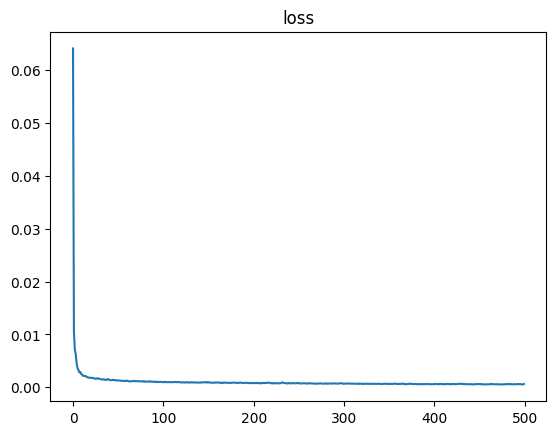

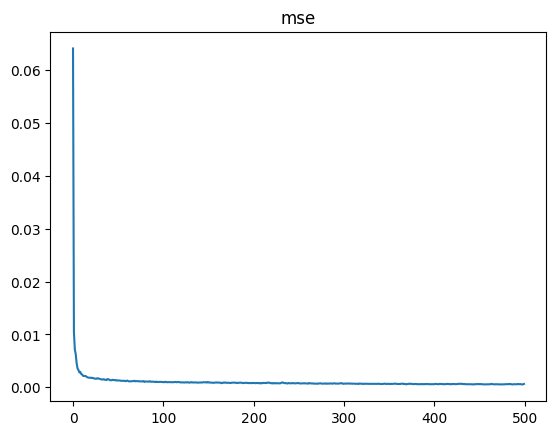

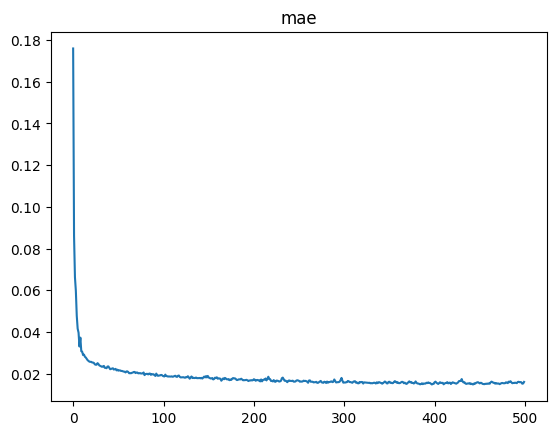

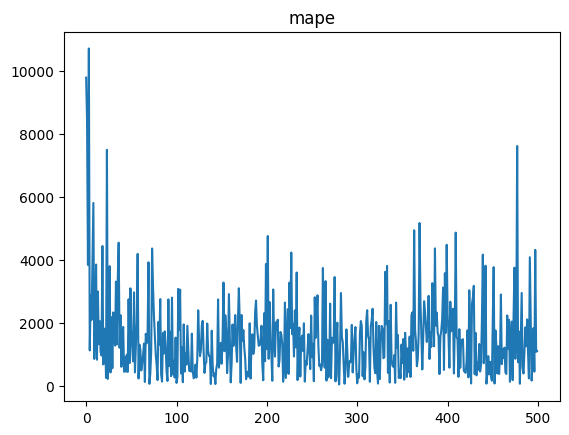

In [16]:
def create_model():
  model = Sequential()
  model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_window.shape[1], len(X_train.columns)))) # layer 1 lstm
  model.add(Dropout(0.2)) # layer 1 dropout regularisation
  model.add(LSTM(units=50, return_sequences=True)) # layer 2 lstm
  model.add(Dropout(0.2)) # layer 2 dropout regularisation
  model.add(LSTM(units=50, return_sequences=True)) # layer 3 lstm
  model.add(Dropout(0.2)) # layer 3 dropout regularisation
  model.add(LSTM(units=50)) # layer 4 lstm
  model.add(Dropout(0.2)) # layer 4 dropout regularisation
  model.add(Dense(units=1)) # output layer
  model.compile(optimizer='adam', loss='mse', metrics=['mse','mae','mape']) # compile the rnn 
  return model

model = create_model()
history = model.fit(X_train_window, y_train_window, epochs=500, batch_size=1500, verbose=2)
model.summary()

for metric in history.history:
  plt.title(metric)
  plt.plot(history.history[metric])
  plt.show()

In [ ]:
'''Optionally save model, model.json and weights.h5'''

model_filename = f'model_{market}_{granularity}_{len(X_train.columns)}-inputs.json'
weights_filename = f'weights_{market}_{granularity}_{len(X_train.columns)}-inputs.h5'

!ls /content

# save structure to json
model_json = model.to_json()
with open(model_filename, 'w') as json_file:
  json_file.write(model_json)

# save weights to hdf5
model.save_weights(weights_filename)

files.download(f'/content/{model_filename}')
files.download(f'/content/{weights_filename}')

model_BTC-GBP_3600_1-inputs.json  sample_data  weights_BTC-GBP_3600_1-inputs.h5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
'''Optionally load model, model.json and weights.h5'''

model_filename = f'model_{market}_{granularity}_{len(X_train.columns)}-inputs.json'
weights_filename = f'weights_{market}_{granularity}_{len(X_train.columns)}-inputs.h5'

try:
  files.upload()
  !ls /content

  # read structure from json
  model = open(model_filename, 'r')
  json = model.read()
  model.close()
  model = model_from_json(json)

  # read weights from hdf5
  model.load_weights(f'/content/{weights_filename}')
except Exception as e:
  print (e)

Saving model_BTC-GBP_3600_1-inputs.json to model_BTC-GBP_3600_1-inputs (1).json
Saving weights_BTC-GBP_3600_1-inputs.h5 to weights_BTC-GBP_3600_1-inputs (1).h5
'model_BTC-GBP_3600_1-inputs (1).json'	'weights_BTC-GBP_3600_1-inputs (1).h5'
 model_BTC-GBP_3600_1-inputs.json	 weights_BTC-GBP_3600_1-inputs.h5
 sample_data


In [17]:
X_scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = X_scaler.fit_transform(X_test)
X_test = pd.DataFrame(X_scaled, columns=[X_test.columns])

print ('X_test inputs:', X_test.columns)

y_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaled = y_scaler.fit_transform(y)
y_test = pd.DataFrame(y_scaled, columns=[y.columns])

print ('y_test inputs:', y_test.columns[0])

X_test_window=[]
y_test_window=[]
for i in range(window, len(X_test)):
  X_test_window.append(X_scaled[i-window:i, :])
  y_test_window.append(X_scaled[i, 0])

X_test_window, y_test_window = np.array(X_test_window), np.array(y_test_window)
X_test_window = np.reshape(X_test_window, (X_test_window.shape[0], X_test_window.shape[1], len(X_test.columns)))

print ('X_test_window.shape:', X_test_window.shape)
print ('y_test_window.shape:', y_test_window.shape)

y_pred = model.predict(X_test_window)
y_pred = y_scaler.inverse_transform(y_pred)

print ('y_pred.shape:', y_pred.shape)

X_test inputs: MultiIndex([(       'open',),
            (       'high',),
            (        'low',),
            (      'close',),
            (     'volume',),
            (      'ema12',),
            (      'ema26',),
            (       'macd',),
            (     'signal',),
            (     'obv_pc',),
            ('close_delta',)],
           )
y_test inputs: ('next_close',)
X_test_window.shape: (2226, 24, 11)
y_test_window.shape: (2226,)
y_pred.shape: (2226, 1)


In [19]:
print ('ae:', mean_absolute_error(df['close'][-len(y_pred):].values, y_pred))
print ('mse:', mean_squared_error(df['close'][-len(y_pred):].values, y_pred, squared=False))
print ('rmse:', mean_squared_error(df['close'][-len(y_pred):].values, y_pred))

ae: 8174.580393774919
mse: 9193.32047520515
rmse: 84517141.35982624


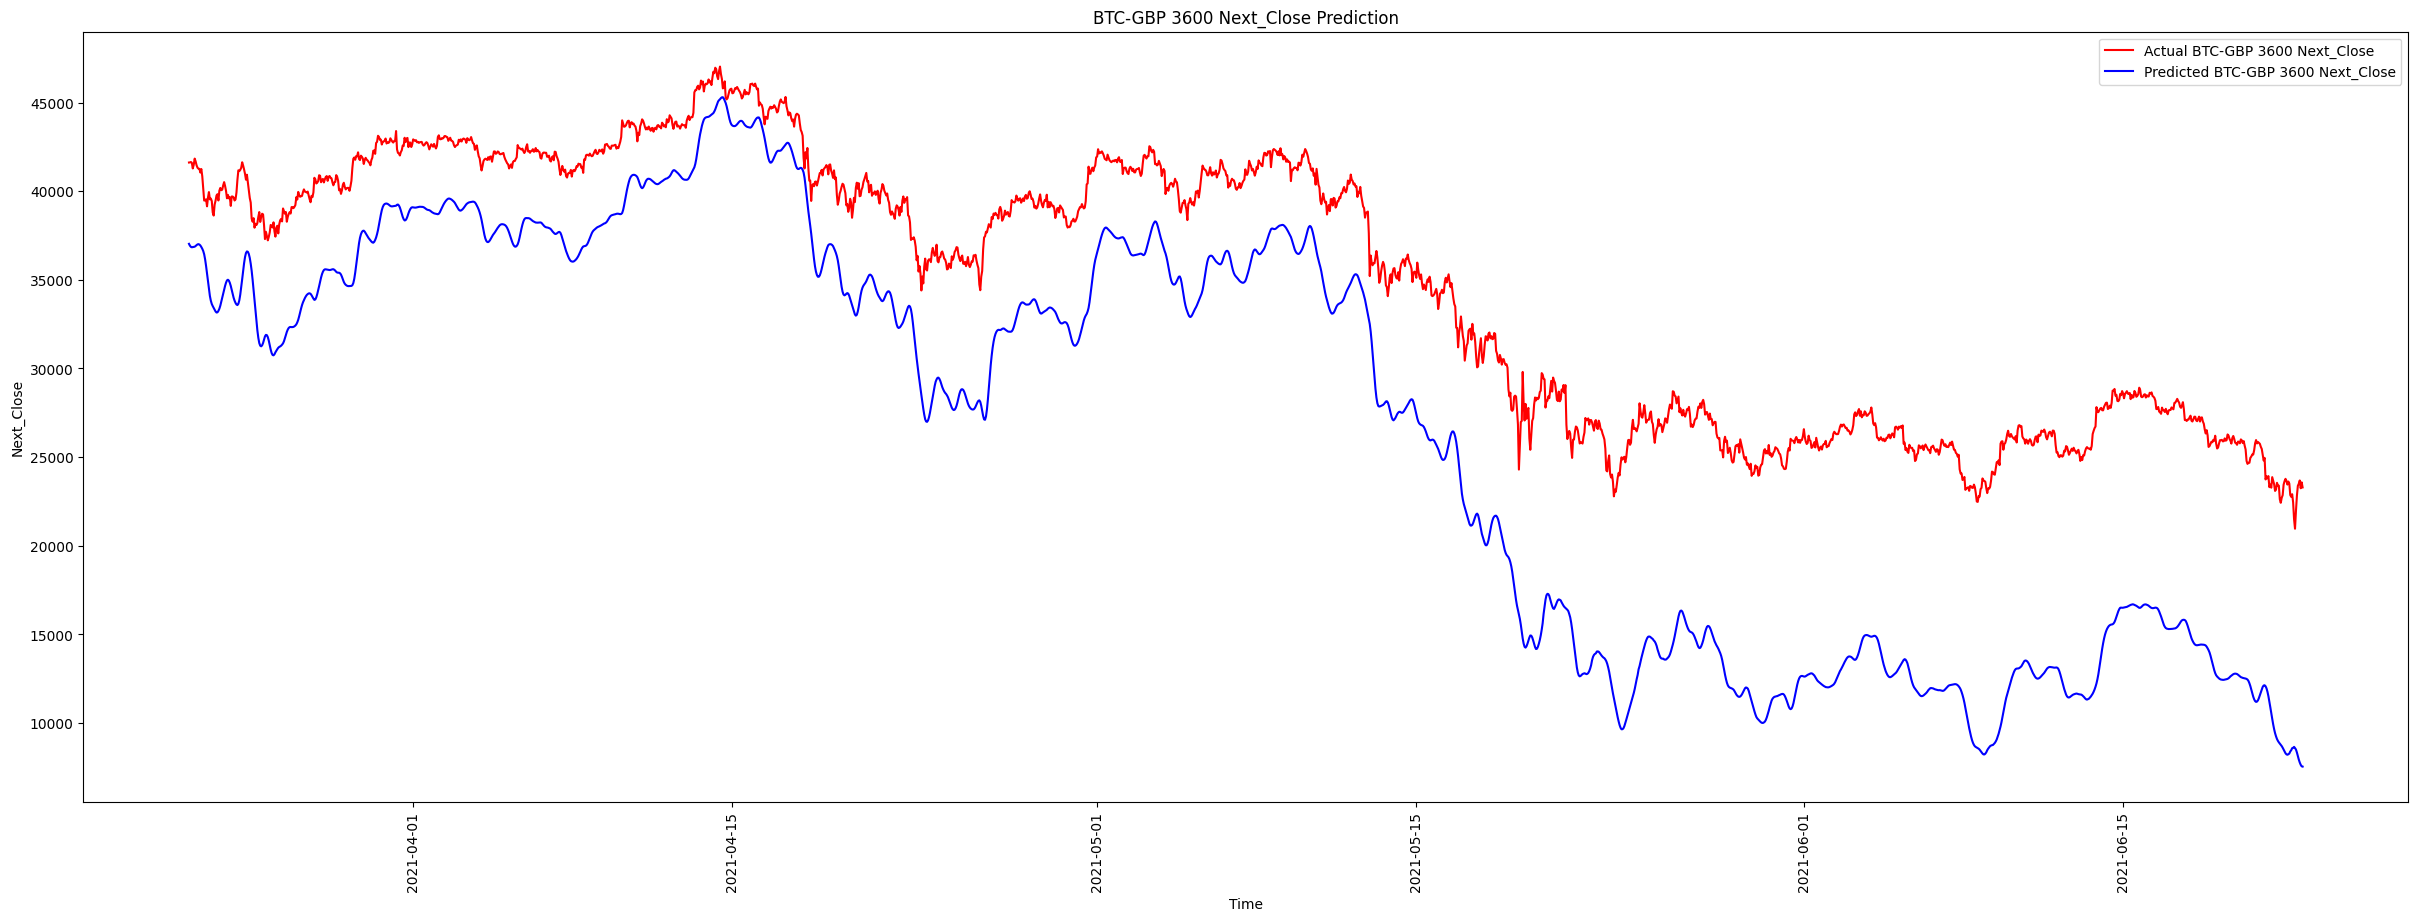

In [23]:
plt.figure(figsize=(30,10))
plt.plot(df['date'].tail(len(y_pred)), df['close'][-len(y_pred):].values, color='red', label=f'Actual {market} {granularity} {y.columns.values[0].title()}')
plt.plot(df['date'].tail(len(y_pred)), y_pred, color='blue', label=f'Predicted {market} {granularity} {y.columns.values[0].title()}')
plt.title(f'{market} {granularity} {y.columns.values[0].title()} Prediction')
plt.xlabel('Time')
plt.ylabel(f'{y.columns.values[0].title()}')
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [24]:
pd.set_option('mode.chained_assignment', None)

df_test = df.tail(len(y_pred))
df_test.loc[:, 'predicted_next_close'] = y_pred
df_test[['open','high','low','close','volume','ema12','ema26','macd','signal','obv_pc','close_delta','next_close']]
df_test.rename(columns={'next_close': 'actual_next_close'}, errors='raise', inplace=True)
df_test

,date,low,high,open,close,volume,ema12,ema26,macd,signal,obv,obv_pc,close_delta,actual_next_close,predicted_next_close
173,2021-03-22 04:00:00,41489.10,41749.99,41640.00,41616.00,6.205647,41433.651005,41494.412398,-60.761393,-103.591805,10381.924037,-0.06,-14.00,41622.00,37029.726562
174,2021-03-22 05:00:00,41406.00,41693.65,41567.67,41622.00,4.190748,41462.627774,41503.863331,-41.235558,-91.120555,10386.114784,0.04,6.00,41644.15,36925.019531
175,2021-03-22 06:00:00,41602.26,41788.54,41622.00,41644.15,17.062060,41490.554270,41514.254936,-23.700666,-77.636578,10403.176844,0.16,22.15,41605.05,36858.949219
176,2021-03-22 07:00:00,41576.00,41756.00,41669.52,41605.05,6.223409,41508.168998,41520.980497,-12.811499,-64.671562,10396.953435,-0.06,-39.10,41280.00,36835.679688
177,2021-03-22 08:00:00,41213.41,41676.00,41583.27,41280.00,14.162843,41473.066075,41503.130090,-30.064015,-57.750052,10382.790592,-0.14,-325.05,41481.92,36844.589844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,2021-06-22 17:00:00,22976.05,23617.59,23369.75,23500.11,228.672950,22786.614814,23070.677236,-284.062422,-391.735605,4835.252502,4.96,115.42,23686.35,7940.043945
295,2021-06-22 18:00:00,23176.00,23888.00,23507.18,23686.35,347.267216,22925.035612,23116.282626,-191.247014,-351.637887,5182.519718,7.18,186.24,23245.22,7776.999023
296,2021-06-22 19:00:00,23123.74,23735.32,23710.16,23245.22,160.309539,22974.294748,23125.833543,-151.538794,-311.618069,5022.210178,-3.09,-441.13,23580.63,7649.151367
297,2021-06-22 20:00:00,23179.20,23643.60,23240.00,23580.63,100.408355,23067.577095,23159.522169,-91.945074,-267.683470,5122.618533,2.00,335.41,23293.27,7564.079102
